<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I - Introduction</h2>

<p>
Ce notebook s’inscrit dans une démarche de <b>comparaison méthodique des
stratégies de prétraitement textuel</b> pour un modèle de classification
multi-classes basé sur un Transformer. L’objectif n’est pas uniquement
d’identifier la stratégie conduisant au meilleur score, mais également de
<b>comprendre l’impact réel des choix de prétraitement</b> sur les performances
et la dynamique d’apprentissage du modèle.
</p>

<p>
L’ensemble des expériences repose sur un cadre strictement contrôlé : le modèle
de base (<i>almanach/camembert-base</i>), les hyperparamètres d’entraînement et les
procédures d’optimisation sont identiques pour toutes les expérimentations. La
seule variable étudiée est la <b>stratégie de prétraitement appliquée aux textes</b>
(titres et descriptions de produits), garantissant ainsi une comparaison
équitable et interprétable.
</p>

<p>
Les stratégies évaluées couvrent un spectre progressif allant du <b>texte brut</b>
à des approches plus élaborées intégrant un nettoyage textuel et différentes
formes d’<b>abstraction numérique</b>, notamment une normalisation ciblée des
grandeurs physiques (longueur, surface, volume, poids). Cette progression permet
d’analyser finement l’apport de chaque niveau de transformation.
</p>

<p>
Les métriques d’entraînement et de validation sont systématiquement enregistrées
via <b>Weights & Biases (W&amp;B)</b>, qui constitue la source de référence pour
l’ensemble des résultats expérimentaux. Ce notebook ne vise pas à relancer les
entraînements, mais à <b>agréger, visualiser et interpréter</b> les résultats issus
de ces logs, selon deux axes complémentaires : la comparaison des performances
finales et l’étude de la dynamique d’apprentissage au fil des époques.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>II – Évaluation comparative des stratégies de prétraitement textuel</h2>

<p>
Cette section présente le cadre expérimental retenu pour comparer différentes
stratégies de prétraitement du texte dans un contexte de classification à l’aide
d’un modèle Transformer pré-entraîné. L’objectif est d’évaluer l’impact de ces
transformations <b>à architecture et hyperparamètres constants</b>.
</p>

<p>
Trois familles de prétraitement sont étudiées :
</p>

<ul>
  <li>
    <b>Texte brut</b>, utilisé comme référence, sans modification du contenu
    lexical.
  </li>
  <li>
    <b>Nettoyage léger (<i>TextCleaner</i>)</b>, limité aux opérations non
    destructives (<code>fix_encoding</code>, <code>unescape_html</code>,
    <code>normalize_unicode</code>), afin de corriger les artefacts techniques
    sans altérer la structure sémantique du texte.
  </li>
  <li>
    <b>Tokenisation numérique (<i>NumericTokens</i>)</b>, selon différentes
    stratégies, visant à remplacer certaines expressions quantitatives par des
    tokens sémantiques discrets, depuis une version <i>light</i> ciblée jusqu’à
    des variantes plus étendues.
  </li>
</ul>

<p>
Toutes les expériences reposent sur le modèle
<b>CamemBERT-base</b> (<code>almanach/camembert-base</code>). Les textes sont
tronqués ou paddés à une longueur maximale de <b>384 tokens</b>, produisant en
sortie une séquence d’embeddings de dimension
<b>384 × 768</b>. La représentation globale du texte est obtenue par un
<b>pooling moyen</b> sur l’ensemble des tokens, avant passage dans un
classifieur composé d’une couche cachée de <b>512 unités</b>.
</p>

<p>
Les hyperparamètres d’entraînement sont maintenus identiques pour l’ensemble des
runs (learning rate = <code>2e-5</code>, batch size = <code>64</code>, scheduler
cosinus avec warmup, <code>8</code> époques), afin de garantir une comparaison
équitable entre les stratégies de prétraitement.
</p>

</div>


<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">
En raison du caractère itératif des expérimentations, le notebook d’entraînement peut ne pas afficher l’ensemble des sorties associées à chaque run. L’intégralité des expériences demeure néanmoins traçable et reproductible via les logs W&B correspondants.
</div>



In [1]:
import sys
sys.path.insert(0, '../src')
from data import load_data
from features.text import NumericTokensTransformer, TextCleaner, MergeTextTransformer
from models.text import TextClassifier, TextDataset
from models import Trainer, EarlyStopping
from utils import load_wandb_runs, load_wandb_history_df
from visualization import plot_classification_report, plot_f1_comparison_with_delta

import torch
from torch.utils.data import DataLoader 
from torch.optim import AdamW
from transformers import AutoTokenizer, get_cosine_schedule_with_warmup

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import wandb

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

def get_extra_tokens_from_transformer(transformer):
    """
    Récupère les extra tokens d'un transformer sklearn ou d'un Pipeline.
    """
    # Cas simple : le transformer expose directement get_extra_tokens
    if hasattr(transformer, "get_extra_tokens"):
        return transformer.get_extra_tokens()

    # Cas Pipeline sklearn
    if isinstance(transformer, Pipeline):
        for _, step in reversed(transformer.steps):
            if hasattr(step, "get_extra_tokens"):
                return step.get_extra_tokens()

    return []


def run_experiment(
    model_name: str,
    preproc_name: str,
    preprocessor,
    run_name: str,
    device: str,

):
    """
    Lance une expérimentation complète pour un couple
    (modèle Transformer, stratégie de prétraitement).

    Tous les hyperparamètres sont figés et identiques entre les runs.
    """

    # =========================
    # Hyperparamètres figés
    # =========================
    MAX_LENGTH = 384
    BATCH_SIZE = 64
    EPOCHS = 8
    MLP_DIM = 512
    LR = 2e-5
    WARMUP_RATIO = 0.1

    # =========================
    # 1️⃣ Prétraitement texte
    # =========================
    X_train_t = preprocessor.fit_transform(X_train)
    X_val_t = preprocessor.transform(X_val)

    # =========================
    # 2️⃣ Tokens additionnels
    # =========================
    extra_tokens = get_extra_tokens_from_transformer(preprocessor)

    # =========================
    # 3️⃣ Tokenizer
    # =========================
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if extra_tokens:
        tokenizer.add_special_tokens(
            {"additional_special_tokens": extra_tokens}
        )

    # =========================
    # 4️⃣ Datasets & loaders
    # =========================
    train_dataset = TextDataset(
        tokenizer, X_train_t, y_train, max_length=MAX_LENGTH
    )
    val_dataset = TextDataset(
        tokenizer, X_val_t, y_val, max_length=MAX_LENGTH
    )

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    # =========================
    # 5️⃣ Modèle
    # =========================
    model = TextClassifier(
        model_name=model_name,
        num_labels=27,
        mlp_dim=MLP_DIM,
        pooling="mean",
    )
    model.backbone.resize_token_embeddings(len(tokenizer) + 1)
    model.to(device)

    # =========================
    # 6️⃣ Optimisation
    # =========================
    optimizer = AdamW(model.parameters(), lr=LR)
    num_training_steps = len(train_loader) * EPOCHS

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(WARMUP_RATIO * num_training_steps),
        num_training_steps=num_training_steps,
    )

    # =========================
    # 7️⃣ W&B init
    # =========================
    wandb.init(
        project="ds_rakuten",
        name=run_name,
        reinit=True,
    )

    wandb.config.update({
        "model": model_name,
        "max_length": MAX_LENGTH,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "mlp_dim": MLP_DIM,
        "scheduler": "cosine_with_warmup",
        "warmup_ratio": WARMUP_RATIO,
        "transformation": preproc_name,
        "n_extra_tokens": len(extra_tokens),
        "vocab_size": len(tokenizer),
    })

    # =========================
    # 8️⃣ Trainer
    # =========================

    run_log_dir = os.path.join(log_dir, name)
    run_ckpt_dir = os.path.join(checkpoint_dir, name)
    os.makedirs(run_log_dir, exist_ok=True)
    os.makedirs(run_ckpt_dir, exist_ok=True)
    
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        scheduler_type="step",
    )

    early_stopping = EarlyStopping(patience=3, mode="max")

    # =========================
    # 9️⃣ Training loop
    # =========================

    print(f"\n===== Entraînement : {run_name} =====")
    
    for epoch in range(1, EPOCHS + 1):
        train_metrics, train_loss = trainer.train_epoch(
            train_loader, epoch
        )
        val_metrics, val_loss = trainer.eval_epoch(
            val_loader, epoch
        )

        wandb.log({
            "epoch": epoch,
            "train/loss": train_loss,
            "train/accuracy": train_metrics["accuracy"],
            "train/f1": train_metrics["f1_weighted"],
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/f1": val_metrics["f1_weighted"],
            **{
                f"lr/group_{i}": g["lr"]
                for i, g in enumerate(optimizer.param_groups)
            },
        })

        if early_stopping.step(val_metrics["f1_weighted"]):
            print("Early stopping déclenché")
            break

    wandb.finish()


# permet de récupérer les extra tokens des pipelines
def get_extra_tokens_from_transformer(transformer):
    """
    Récupère les extra tokens d'un transformer sklearn ou d'un Pipeline.
    """
    # Cas simple : le transformer expose directement get_extra_tokens
    if hasattr(transformer, "get_extra_tokens"):
        return transformer.get_extra_tokens()

    # Cas Pipeline sklearn
    if isinstance(transformer, Pipeline):
        for _, step in reversed(transformer.steps):
            if hasattr(step, "get_extra_tokens"):
                return step.get_extra_tokens()

    return []

In [5]:
# transformer
model_name = "almanach/camembert-base"

# preprocessing testé
preprocessors = {
    "texte brute" : MergeTextTransformer(sep="[SEP]"),
    "cleaner" : Pipeline([
        ('cleaner', TextCleaner(remove_html_tags=False)),
        ('merger', MergeTextTransformer(sep="[SEP]"))
    ]),
    "numtok ligth" : NumericTokensTransformer(strategy='light'),
    "numtok full" : NumericTokensTransformer(strategy='full'),
    "cleaner + numtok ligth" : Pipeline([
        ('cleaner', TextCleaner(remove_html_tags=False)),
        ('numtok', NumericTokensTransformer(strategy='light'))
    ]),
    "numtok phys" : NumericTokensTransformer(strategy='phys'),
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# for preproc_name, preprocessor in preprocessors.items():
#     run_name = f"camembert_{preproc_name}"
#     run_experiment(model_name, preproc_name, preprocessor, run_name, device)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse des résultats</h3>

<p>
Les résultats des différentes expérimentations ont été <b>préalablement extraits
et consolidés sous forme de fichiers CSV</b>. Ces fichiers contiennent les
métriques d’entraînement et de validation nécessaires à la comparaison des
stratégies de prétraitement.
</p>

<p>
La suite de ce notebook repose exclusivement sur l’analyse de ces données afin de se concentrer sur
l’interprétation des performances et de la dynamique d’apprentissage.
</p>

</div>


In [29]:
project_path = "beautiful-pixel-formation-data-science/ds_rakuten"
run_names = [f"camembert_{preproc_name}" for preproc_name in preprocessors]
runs = load_wandb_runs(project_path, run_names)
history_df = load_wandb_history_df(runs)

history_df.head(3)

,_step,epoch,train/loss,train/f1,val/loss,val/f1,name
0,0,1,1.555173,0.571871,0.591768,0.825839,camembert_texte brute
1,1,2,0.511187,0.844998,0.449098,0.858844,camembert_texte brute
2,2,3,0.371084,0.885231,0.391720,0.881255,camembert_texte brute


In [35]:
best_f1_df = (
    history_df
    .sort_values("val/f1", ascending=False)
    .groupby("name", as_index=False)
    .first()
    .drop('_step', axis=1)
)

best_f1_df = best_f1_df.sort_values("val/f1", ascending=False)

print("-"*25 + " meilleurs f1 de validation par stratégie "+"-"*25)

display(best_f1_df.round(4))


------------------------- meilleurs f1 de validation par stratégie -------------------------


,name,epoch,train/loss,train/f1,val/loss,val/f1
5,camembert_texte brute,8,0.1359,0.9595,0.3786,0.8961
3,camembert_numtok ligth,8,0.1371,0.9590,0.3730,0.8958
4,camembert_numtok phys,8,0.1375,0.9584,0.3772,0.8944
0,camembert_cleaner,7,0.1489,0.9533,0.3747,0.8944
1,camembert_cleaner + numtok ligth,8,0.1392,0.9580,0.3786,0.8929
2,camembert_numtok full,7,0.1622,0.9488,0.3843,0.8913


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les résultats obtenus montrent que les différentes stratégies de prétraitement
ont un impact <b>mesuré mais significatif</b> sur les performances du modèle. Le
<b>texte brut</b> constitue une référence solide et atteint le meilleur score F1
de validation, illustrant la capacité du modèle Transformer à exploiter
directement les signaux lexicaux et contextuels présents dans les données.
</p>

<p>
Les stratégies de <b>tokenisation numérique légère</b>, en particulier
<i>numtok light</i> et <i>numtok phys</i>, obtiennent des performances très proches
du texte brut, avec une <b>loss de validation plus faible</b>. Cela suggère qu’une
abstraction numérique ciblée peut améliorer la qualité des probabilités prédites
sans dégrader la capacité de discrimination du modèle.
</p>

<p>
À l’inverse, les approches combinant nettoyage textuel et normalisation
numérique, ainsi que la stratégie <i>numtok full</i>, montrent une baisse plus nette
des performances. Ces résultats indiquent que des <b>prétraitements trop
agressifs</b> tendent à supprimer ou homogénéiser des signaux utiles, déjà bien
pris en charge par le pré-entraînement du Transformer.
</p>

<p>
Dans l’ensemble, ces observations confirment qu’avec des modèles pré-entraînés,
une approche de prétraitement <b>conservatrice et ciblée</b> est préférable à une
normalisation extensive, afin de préserver la richesse informative du texte.
</p>

<p>
Au regard de ces résultats globaux, deux stratégies se distinguent par leurs
performances et leur comportement complémentaire : le <b>texte brut</b> et la
<b>tokenisation numérique légère (<i>numtok light</i>)</b>. Nous proposons donc
d’analyser plus en détail ces deux approches, en étudiant leur dynamique
d’apprentissage et l’évolution de leurs métriques au fil des époques.
</p>

</div>

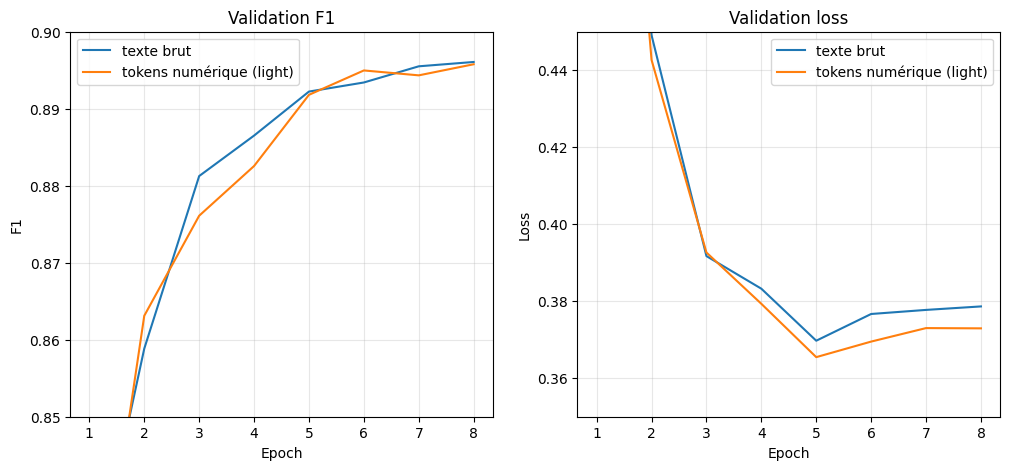

In [22]:
texte_brut = history_df[history_df['name'] == "camembert_texte brute"]
numtok_ligth = history_df[history_df['name'] == "camembert_numtok ligth"]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(texte_brut['epoch'], texte_brut['val/f1'], label='texte brut')
ax1.plot(numtok_ligth['epoch'], numtok_ligth['val/f1'], label='tokens numérique (light)')
ax1.set_title("Validation F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("F1")
ax1.legend()
ax1.set_ylim(0.85, 0.9)

ax2.plot(texte_brut['epoch'], texte_brut['val/loss'], label='texte brut')
ax2.plot(numtok_ligth['epoch'], numtok_ligth['val/loss'], label='tokens numérique (light)')
ax2.set_title("Validation loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.set_ylim(0.35, 0.45)
ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)
plt.show()

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse ciblée : texte brut vs numtok light</h3>

<p>
La comparaison des courbes de <b>F1 de validation</b> montre que les deux stratégies
présentent des performances très proches tout au long de l’entraînement. Les
courbes s’entrelacent d’une époque à l’autre, indiquant qu’aucune des deux
approches ne domine clairement l’autre en termes de capacité de classification
pure. Le texte brut conserve un avantage marginal sur le F1 final, mais cet
écart reste très limité.
</p>

<p>
En revanche, l’analyse de la <b>loss de validation</b> met en évidence une différence
plus structurelle. La stratégie <i>numtok light</i> atteint une loss plus faible et
plus stable à partir des époques intermédiaires, tandis que la loss du texte brut
reste légèrement plus élevée en fin d’entraînement. Cette observation suggère
une meilleure <b>calibration des probabilités</b> pour <i>numtok light</i>.
</p>

<p>
Ces résultats indiquent que, bien que le texte brut soit légèrement supérieur en
termes de F1 final, <i>numtok light</i> produit des sorties probabilistes plus
informées et plus régulières. Dans cette optique, <b>numtok light constitue un
meilleur candidat pour une stratégie de stacking ou de blending</b>, où la qualité
des probabilités est un critère central.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III – Influence de la capacité du modèle sur l’apport du prétraitement</h2>

<p>
L’analyse précédente met en évidence un comportement intéressant : si le texte
brut conserve un avantage marginal en termes de <b>F1 de validation</b>, la
stratégie <i>numtok light</i> se distingue par une <b>loss plus faible et plus
stable</b>, suggérant une meilleure calibration des probabilités et un intérêt
particulier pour des approches de type stacking.
</p>

<p>
Ces résultats ont toutefois été obtenus avec un modèle de capacité fixe
(<b>CamemBERT-base</b>). Il est donc légitime de s’interroger sur la généralité de
ces observations : l’apport de la tokenisation numérique légère est-il inhérent au
prétraitement, ou constitue-t-il un biais inductif compensant les limites de
capacité du modèle ?
</p>

<p>
Afin de répondre à cette question, nous reproduisons le même protocole
expérimental en remplaçant uniquement le modèle sous-jacent par
<b>CamemBERT-large</b>, disposant d’une capacité de représentation et d’un contexte
plus étendus. Cette extension vise à évaluer si un modèle plus expressif est en
mesure d’exploiter efficacement les informations quantitatives brutes, réduisant
ainsi l’intérêt d’un prétraitement numérique explicite.
</p>

</div>



In [2]:
model_name = "almanach/camembert-large"

# for preproc_name, preprocessor in preprocessors.items():
#     if preproc_name in ['texte brute', 'numtok ligth']
#     run_name = f"camembert_large_{preproc_name}"
#     run_experiment(model_name, preproc_name, preprocessor, run_name, device)

In [42]:
run_names = [f"camembert_large_{preproc_name}" for preproc_name in ['texte brute', 'numtok ligth']]
runs = load_wandb_runs(project_path, run_names)
history_large_df = load_wandb_history_df(runs)

history_large_df.head(3)

,_step,epoch,train/loss,train/f1,val/loss,val/f1,name
0,0,1,1.245745,0.661857,0.510845,0.845048,camembert_large_texte brute
1,1,2,0.420290,0.870383,0.377155,0.884317,camembert_large_texte brute
2,2,3,0.285920,0.910420,0.358154,0.891920,camembert_large_texte brute


In [43]:
best_f1_large_df = (
    history_large_df
    .sort_values("val/f1", ascending=False)
    .groupby("name", as_index=False)
    .first()
    .drop('_step', axis=1)
)

print("-"*25 + " meilleurs f1 de validation par stratégie "+"-"*25)

pd.concat([best_f1_df.iloc[:2], best_f1_large_df], axis=0).sort_values("val/f1", ascending=False).round(4)

------------------------- meilleurs f1 de validation par stratégie -------------------------


,name,epoch,train/loss,train/f1,val/loss,val/f1
0,camembert_large_numtok ligth,8,0.0373,0.9896,0.4062,0.9106
1,camembert_large_texte brute,7,0.0514,0.9843,0.4067,0.9096
5,camembert_texte brute,8,0.1359,0.9595,0.3786,0.8961
3,camembert_numtok ligth,8,0.1371,0.9590,0.3730,0.8958


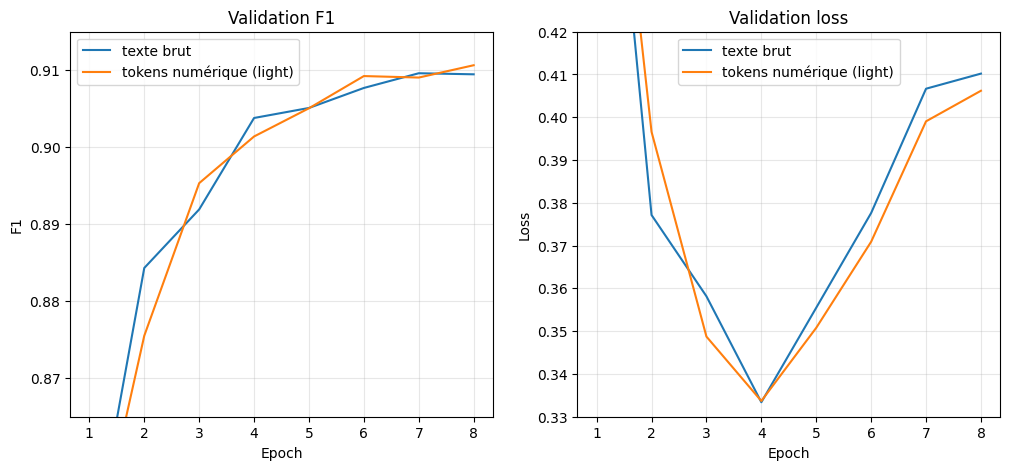

In [57]:
texte_brut = history_large_df[history_large_df['name'] == "camembert_large_texte brute"]
numtok_ligth = history_large_df[history_large_df['name'] == "camembert_large_numtok ligth"]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(texte_brut['epoch'], texte_brut['val/f1'], label='texte brut')
ax1.plot(numtok_ligth['epoch'], numtok_ligth['val/f1'], label='tokens numérique (light)')
ax1.set_title("Validation F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("F1")
ax1.legend()
ax1.set_ylim(0.865, 0.915)

ax2.plot(texte_brut['epoch'], texte_brut['val/loss'], label='texte brut')
ax2.plot(numtok_ligth['epoch'], numtok_ligth['val/loss'], label='tokens numérique (light)')
ax2.set_title("Validation loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.set_ylim(0.33, 0.42)
ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)
plt.show()

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse des résultats : effet conjoint du prétraitement et de la capacité du modèle</h3>

<p>
L’augmentation de la capacité du modèle, via le passage de
<b>CamemBERT-base</b> à <b>CamemBERT-large</b>, conduit à une amélioration nette et
cohérente des performances pour les deux stratégies de prétraitement. Le meilleur
<b>F1 de validation</b> passe d’environ <b>0.896</b> avec le modèle de base à plus de
<b>0.91</b> avec le modèle large, confirmant l’impact majeur de la capacité de
représentation du Transformer sur la qualité de la classification.
</p>

<p>
Avec CamemBERT-large, l’écart de <b>loss de validation</b> entre les deux stratégies
se réduit par rapport à CamemBERT-base, traduisant une meilleure capacité du
modèle à exploiter le texte brut sans normalisation explicite. Néanmoins,
<i>numtok light</i> conserve une loss systématiquement plus faible à partir des époques intermédiaires, indiquant des prédictions plus stables et mieux calibrées.
</p>

<p>
En revanche, les scores de <b>F1 de validation</b> restent très proches et peuvent
s’inverser selon les époques ou la capacité du modèle. Cette variabilité suggère
que le gain en F1 n’est pas structurel, mais dépend davantage de la dynamique
d’apprentissage que du prétraitement lui-même.
</p>

<p>
Ainsi, même avec un modèle de plus grande capacité, <i>numtok light</i> apparaît
comme une stratégie plus robuste du point de vue probabiliste. Ce critère étant
central pour des approches de <b>stacking ou de blending</b>, <i>numtok light</i> demeure
le choix le plus pertinent à privilégier, indépendamment de la taille du modèle.
</p>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>IV - Évaluation finale et comparaison des modèles</h2>

<p>
À l’issue de l’analyse comparative menée sur les différentes stratégies de
prétraitement et architectures, le modèle
<b>CamemBERT-large avec prétraitement numtok light</b> a été retenu comme
la configuration la plus performante. Le modèle sélectionné correspond à
l’<b>epoch 8</b>, présentant le meilleur F1-score sur le jeu de validation.
</p>

<p>
Dans cette section, nous procédons à une <b>évaluation finale sur le jeu de test
indépendant</b>, afin d’estimer les performances réelles du modèle dans un cadre
entièrement non supervisé et de disposer d’une base de référence solide pour les
étapes ultérieures de fusion de modèles.
</p>

<p>
Les résultats obtenus sont ensuite <b>analysés en détail et comparés</b> à ceux du
modèle de <b>classification basé sur une vectorisation du texte brut</b>, présenté
dans le notebook <i>text_04_vectorization.ipynb</i>. Cette comparaison permet d’évaluer les gains apportés
par l’approche Transformer, tant en termes de performance globale que de
comportement par catégorie.
</p>

</div>

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">
Les prédictions du jeu de test sont directement réimportées dans ce notebook.
Le code d’inférence a volontairement été retiré afin d’améliorer la lisibilité
et de se concentrer sur l’analyse des résultats.
</div>


In [15]:
y_proba = np.load("../predictions/text/proba_camembert_test.npy")
y_pred_cam = np.argmax(y_proba, axis=1)
y_pred_vec = np.load("../predictions/text/pred_vec_test.npy")

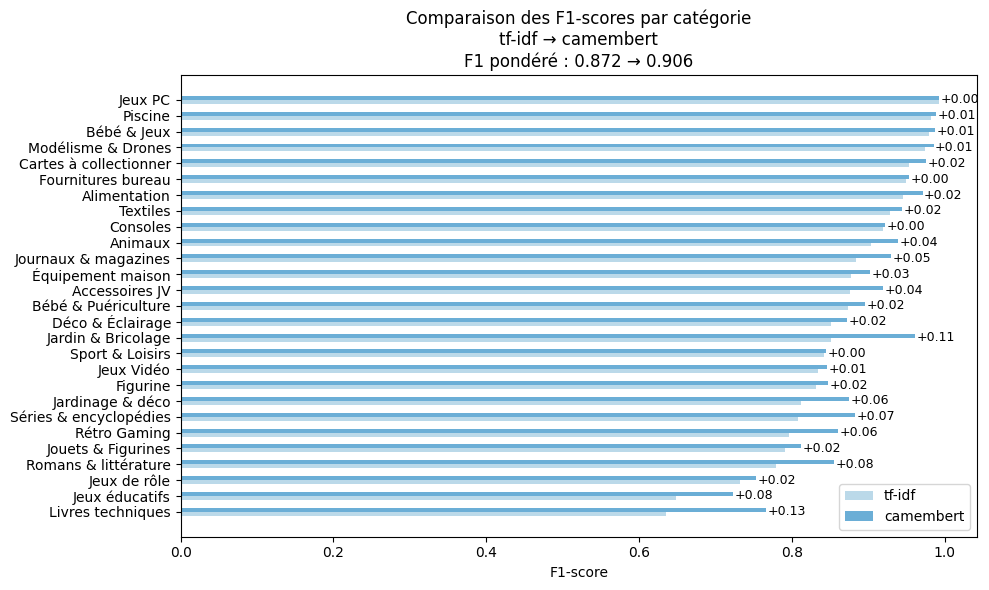

F1 weighted score : 0.906
Accuracy : 0.91


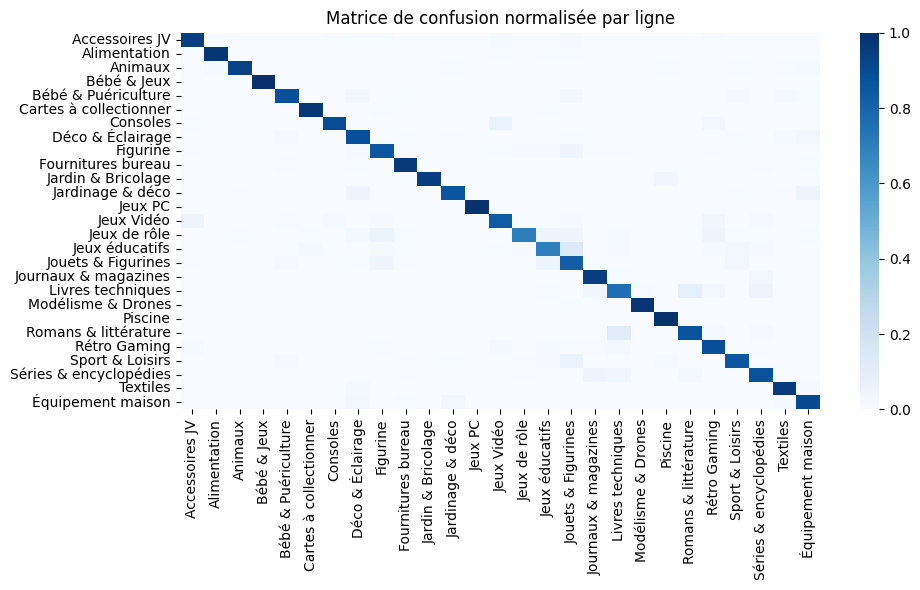

,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,13.8
1,Romans & littérature,Livres techniques,11.4
2,Livres techniques,Romans & littérature,9.2
3,Sport & Loisirs,Jouets & Figurines,7.0
4,Consoles,Jeux Vidéo,6.4


In [17]:
plot_f1_comparison_with_delta(y_test, y_pred_cam, y_pred_vec, ref_name='tf-idf', new_name='camembert', encoder=encoder)
plot_classification_report(y_test, y_pred_cam, k_worst_f1=None, k_worst_errors=5, encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse par catégorie : CamemBERT-large vs vectorisation tf-idf</h3>

<p>
À l’échelle globale, le <b>F1-score pondéré</b> s’améliore nettement par rapport au
modèle de vectorisation classique, en passant de <b>0.872 à 0.906</b>. Ce gain
confirme l’apport significatif de l’architecture Transformer.
</p>

<p>
Un premier constat important est que <b>toutes les catégories bénéficient d’un gain
positif ou nul</b>. Aucune dégradation n’est observée, ce qui indique que l’approche
basée sur <b>CamemBERT-large avec numtok light</b> est strictement dominante par
rapport à la vectorisation du texte brut.
</p>

<p>
Les améliorations les plus marquées concernent des catégories <b>plus complexes ou
plus hétérogènes</b>, telles que <b>Jardin &amp; Bricolage</b>, <b>Jardinage &amp; déco</b>, ainsi
que des catégories historiquement difficiles à discriminer car souvent confondues
entre elles, comme <b>Livres techniques</b>, <b>Romans &amp; littérature</b> et
<b>Séries &amp; encyclopédies</b> ou <b>Jeux éducatifs</b> et <b>Jouets &amp; Figurines</b>.
Sur ces classes, les gains peuvent dépasser <b>+10 points de F1</b>.
</p>

<p>
Ces catégories sont typiquement riches en descriptions techniques, quantitatives
ou semi-structurées, pour lesquelles la compréhension fine du contexte et des
expressions numériques joue un rôle clé.
</p>

<p>
Dans l’ensemble, ces résultats montrent que l’utilisation de <b>CamemBERT-large</b>, permet une <b>meilleure modélisation
du contenu informatif du texte</b>, en particulier dans les cas où les approches de
vectorisation classiques atteignent leurs limites.
</p>

</div>